In [ ]:
pip install -q optax dm-haiku

In [ ]:
import jax
import jax.numpy as jnp
import optax
import haiku as hk

In [232]:
γ = 2.
β = 0.95
rf = 1.0104

def stock_return(rng):
  μs = 0.06
  σs = 0.2
  ε = jax.random.normal(rng, ())
  log_return = μs + σs * ε
  return jnp.exp(log_return)

def U(c):
    return c**(1 - γ) / (1 - γ)

optimizer = optax.adam
lr = 1e-3
T = 50

def nnet(x,a):
  X, A = jnp.column_stack([x]), jnp.column_stack([a])
  X, A = hk.Linear(32)(X), hk.Linear(32)(A)
  X, A = jnp.tanh(X), jnp.tanh(A)
  X, A = hk.Linear(1)(X), hk.Linear(1)(A)
  X, A = jnp.squeeze(X), jnp.squeeze(A)
  return X, A

init, nnet = hk.without_apply_rng(hk.transform(nnet))
rng = jax.random.PRNGKey(0)
Θ = init(rng, jnp.array(1.), jnp.array(.5))

opt_state = optimizer(lr).init(Θ)

In [ ]:
########## Loss function
def L(Θ, rng):

  x = 1.
  α = .5
  G = 0.

  state = x, α

  inputs = jnp.arange(T)
##########################################################

# creating a vector of returns for different time

  def ret(rng, inputs):
    rng, _ = jax.random.split(rng)
    R = stock_return(rng)
    return rng, R
  rng, R = jax.lax.scan(ret, rng, inputs) 
##########################################################
    
  def core(state, inputs):
    t = inputs
    xt, at = state
    r = R[inputs-1]# selecting a randomly generated return 
    ct = jax.nn.sigmoid(nnet(Θ, xt, at)[0] - 4.) * xt
    αt = jax.nn.sigmoid(nnet(Θ, xt, at)[1]) 
    ut = U(ct)
    st = xt - ct # savings = st
    rfinv = (1 - αt) * (st) * (rf) # riskfree investment
    rinv = (αt) * (st) * (r) # risky investment
    x_tp1 = rfinv + rinv # generating new state with savings growing at rate r
    s_tp1 = x_tp1, αt

    discounted_utility = β**t * ut
    return s_tp1, discounted_utility

  state, discounted_utility = jax.lax.scan(core, state, inputs)
  G = discounted_utility.sum()
  return -G


@jax.jit
def evaluation(Θ, rng):
  return -L(Θ, rng)


@jax.jit
def update_gradient_descent(Θ, opt_state, rng):
  rng, _ = jax.random.split(rng)
  grad = jax.grad(L)(Θ,rng)
  updates, opt_state = optimizer(lr).update(grad, opt_state)
  Θ = optax.apply_updates(Θ, updates)
  return Θ, opt_state, rng

In [ ]:
for iteration in range(100000):
  rng = jax.random.PRNGKey(0)
  Θ, opt_state, rng = update_gradient_descent(Θ, opt_state, rng)
  

  if iteration % 1000 == 0:
    print(evaluation(Θ, rng))

-1730.3457
-447.62466
-442.90622
-442.17316
-440.96854
-438.41586
-437.33203
-436.87802
-436.7887
-436.22086
-436.0071
-435.90558
-435.7611
-435.6327
-435.51956
-435.4186
-435.32953
-435.24622
-435.17224
-435.10455
-435.04028
-434.98523
-434.9312
-434.87988
-434.8335
-434.79266
-434.7522
-434.71255
-434.6795
-434.6464
-434.61462
-434.58508
-434.55746
-434.52866
-434.50467
-434.48047
-434.45837
-434.43744
-434.41644
-434.3971
-434.3772
-434.3601
-434.34186
-434.32422
-434.30847
-434.29587
-434.2782
-434.2635
-434.25394
-434.23953
-434.2257
-434.21338
-434.20053
-434.193
-434.1789
-434.17004
-434.16003
-434.14746
-434.1416
-434.13013
-434.11853
-434.1101
-434.10367
-434.09705
-434.08902
-434.07867
-434.07373
-434.065
-434.05798
-434.05066
-434.04248
-434.0375
-434.02823
-434.02603
-434.0171
-434.01413
-434.0066
-433.99988
-433.9958
-433.98737
-433.98254
-433.9809
-433.97498
-433.9702
-433.96396
-433.96378
-433.95605
-433.9506
-433.94843
-433.94376
-433.9393
-433.93237
-433.92938
-433.924

In [ ]:

def rplot(Θ, rng):

  x = 1.
  α = .5
  G = 0.

  state = x, α

  inputs = jnp.arange(T)
##########################################################

# creating a vector of returns for different time

  def ret(rng, inputs):
    rng, _ = jax.random.split(rng)
    R = stock_return(rng)
    return rng, R
  rng, R = jax.lax.scan(ret, rng, inputs) 
##########################################################
    
  def core2(state, inputs):
    t = inputs
    xt, at = state
    r = R[inputs-1]# selecting a randomly generated return 
    ct = jax.nn.sigmoid(nnet(Θ, xt, at)[0] - 4.) * xt
    αt = jax.nn.sigmoid(nnet(Θ, xt, at)[1])
    ut = U(ct)
    st = xt - ct # savings = st
    rfinv = (1-αt) * (st) * (rf) # riskfree investment
    rinv = (αt) * (st) * (r) # risky investment
    x_tp1 = rfinv + rinv # generating new state with savings growing at rate r
    c2x = ct/xt

    s_tp1 = x_tp1, αt    
    results = c2x, αt
    
    return s_tp1, results

  state, results = jax.lax.scan(core2, state, inputs)
  
  return results

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm

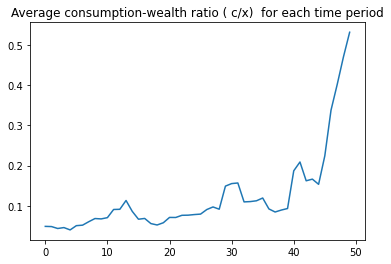

In [ ]:
plt.title("Average consumption-wealth ratio ( c/x)  for each time period")
plt.plot(rplot(Θ, rng)[0]);

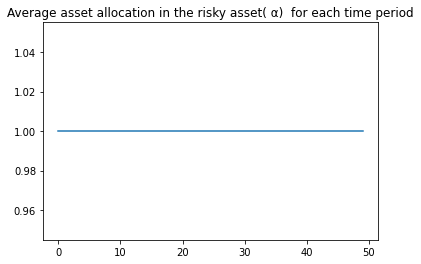

In [220]:
plt.title("Average asset allocation in the risky asset( α)  for each time period")

plt.plot(rplot(Θ, rng)[1]);

In [228]:
theta_1 = Θ
rplot(theta_1, rng)[1]

DeviceArray([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
             1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
             1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
             1., 1., 1., 1., 1.], dtype=float32)

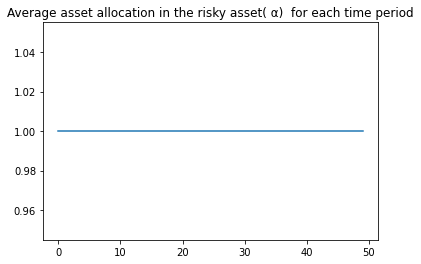

In [229]:
plt.title("Average asset allocation in the risky asset( α)  for each time period")

plt.plot(rplot(theta_1, rng)[1]); 

***It is observed that after million iterations the alpha value has remained constant at 1, while when the iternations it can be observed that it is getting closer to 1 as illustrated below***

In [233]:
for iteration in range(10000):
  rng = jax.random.PRNGKey(0)
  Θ, opt_state, rng = update_gradient_descent(Θ, opt_state, rng)
  

  if iteration % 1000 == 0:
    print(evaluation(Θ, rng))

-1730.3457
-447.62466
-442.90622
-442.17316
-440.96854
-438.41586
-437.33203
-436.87802
-436.7887
-436.22086


In [234]:
theta_2 = Θ
rplot(theta_2, rng)[1]

DeviceArray([0.9999713, 0.9999945, 0.9999945, 0.9999945, 0.9999945,
             0.9999945, 0.9999945, 0.9999945, 0.9999945, 0.9999945,
             0.9999945, 0.9999945, 0.9999945, 0.9999945, 0.9999945,
             0.9999945, 0.9999945, 0.9999945, 0.9999945, 0.9999945,
             0.9999945, 0.9999945, 0.9999945, 0.9999945, 0.9999945,
             0.9999945, 0.9999945, 0.9999945, 0.9999945, 0.9999945,
             0.9999945, 0.9999945, 0.9999945, 0.9999945, 0.9999945,
             0.9999945, 0.9999945, 0.9999945, 0.9999945, 0.9999945,
             0.9999945, 0.9999945, 0.9999945, 0.9999945, 0.9999945,
             0.9999945, 0.9999945, 0.9999945, 0.9999945, 0.9999945],            dtype=float32)

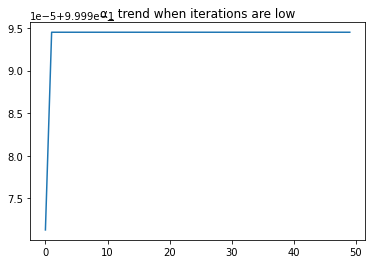

In [235]:
plt.title("α_ trend when iterations are low")
plt.plot(rplot(theta_2, rng)[1]); 